# Mean-Variance Portfolio Optimization with a Risk-Free Asset
This script performs an event study analysis to calculate Cumulative Abnormal Returns (CAR) and Cumulative Average Abnormal Returns (CAAR) around specific events, using a CAPM model for expected returns in Python.

**Source:** Essentials of Financial Economics  
**Authors:** Michael Donadelli, Michele Costola, Ivan Gufler  
**Date:** May 8, 2025

## 0. Preliminaries

This script computes the Cumulative Abnormal Returns around large aviation disasters (more than 150 casualties) between 1972 and 2007. The teoretical return is computed according to a one-factor CAPM model, using market excess returns from Fama and French library. The test asset is the Transport industry from 49 Industry portfolio retrieved from Fama and French library.

## 1. Import libraries

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta # Import timedelta specifically
import statsmodels.api as sm
import matplotlib.pyplot as plt

## 2. Settings

We compute the CARs from $t-1$ to $t+5$ relative to the disaster date. The CAPM model is estimated using data from $t-250$ to $t-50$.

In [35]:
America = 0  # Flag: 1 to use only aviation disasters in America, 0 for all
cutoff = 150  # Cutoff for number of casualties to filter events

# Define the Cumulative Abnormal Return (CAR) window relative to event day (day 0)
start_CAR = -5
end_CAR = 15

# Define the CAPM estimation window relative to event day (day 0)
start_CAPM = -250
end_CAPM = -100

## 3. Load and Prepare Data

In [43]:
# Import industry portfolio returns (assuming it includes Transport industry)
Portfolios = pd.read_excel("../Data/IndustryPortfolios.xlsx")
# Import daily Fama-French Factors
Factors = pd.read_excel('../Data/FF_FactorsDaily.xlsx')
# Import Events data
Events = pd.read_excel('../Data/Events.xlsx')

# Filter events based on the America flag and casualty cutoff
if America == 0:
    # Filter for all events above the cutoff (assuming casualties are in column 12, event date in column 3)
    Events = Events[Events.iloc[:, 12] > cutoff].iloc[:, 3]
else:
    # Filter for events in Zone 1 (America, assuming Zone is in the last column, index -1) above the cutoff
    Events = Events[(Events.iloc[:, 12] > cutoff) & (Events.iloc[:, -1] == 1)].iloc[:, 3]

# Extract Market Excess Return (Mkt-RF)
MktRet = np.array(Factors.iloc[:, 1]) / 100
# Extract Risk-Free Rate (RF)
Rf = np.array(Factors.iloc[:, 4]) / 100

Ret = np.array(Portfolios.iloc[:, 13]) / 100  # Transport industry returns

# Calculate Excess Returns for the Transport industry
ExRet = Ret - Rf

# Convert event dates and returns dates to datetime objects
Events = [datetime.strptime(str(date), '%d-%m-%Y') for date in Events]
DatesReturn = [datetime.strptime(str(date), '%Y%m%d') for date in Factors.iloc[:, 0]]

n = ExRet.shape

# Get the index in the Returns dates that corresponds to each event date
Dates = []
# Loop through each event date
for event_date in Events:
    # While the current event_date is not found in DatesReturn
    while event_date not in DatesReturn:
        # Move to the next day
        event_date += timedelta(days=1)
    # Once the event_date is found (or the next trading day is found), get its index
    Dates.append(DatesReturn.index(event_date))

# Convert the list of indices to a numpy array
Dates = np.array(Dates)
# Filter out event dates where the estimation window would go before the start of the data
# Keep only event dates where the start of the CAPM estimation window (Dates[i] + start_CAPM) is >= 0 (Python index)
Dates = Dates[Dates > abs(start_CAPM)] # Assuming start_CAPM is negative
# Remove duplicate event dates if any
Dates = np.unique(Dates)
# Get the number of valid events
nE = len(Dates)

print("Number of events: ", nE)


Number of events:  53


## 4. Estimate CAPM

The theoretical returns are estimated according to a CAPM model:

$$
z_{t} = \alpha + \beta_{M}\, z_{M,t} + \varepsilon_{i,t}
$$

where $z_{t}$ are the Transportation industry portfolio excess returns and z_{M,t} are market excess returns.

For each event $e$ occurring at time $t$ we compute the estimates $\hat{\alpha}$ and $\hat{\beta}$ using data from $t-250$ and $t-50$, relative to the event date. 

In [37]:

# Preallocate arrays for CAPM coefficients (alpha and beta) for each valid event
alpha = np.empty((nE, 1))
alpha[:] = np.nan 
beta = np.empty((nE, 1))
beta[:] = np.nan

# Compute the CAPM model for each valid event in the specified estimation window
for i in range(nE):
    # Define the start and end indices for the estimation window relative to the event date index
    start_index = Dates[i] + start_CAPM
    end_index = Dates[i] + end_CAPM

    # Extract the data for the current estimation window for Market Excess Return (X) and Asset Excess Return (y)
    X = MktRet[start_index:end_index+1]
    y = ExRet[start_index:end_index+1]

    # Add a constant term to the independent variable (X) for the intercept (alpha) in the OLS regression
    X = sm.add_constant(X)
    # Fit the linear regression model using statsmodels (OLS)
    model = sm.OLS(y, X)
    results = model.fit()

    # Store the estimated coefficients (alpha and beta)
    alpha[i, 0] = results.params[0]
    beta[i, 0] = results.params[1]


## 5. Compute theoretical and abnormal returns


The theoretical return is given by:

$$
\hat{z}_{t, e} = \hat{\alpha} + \hat{\beta} z_{M,t, e}
$$

Finally, the abnormal returns, defined as the different between \emph{realized} and theoretical returns, around the event windows $t-1$ and $t+5$ are given by:

$$
AR_{t,e} = z_{t} - \hat{z}_{t,e}
$$

In [38]:
# Preallocate array for CAPM predicted returns around events
PredRet = np.empty((abs(start_CAR) + abs(end_CAR) + 1, nE))
PredRet[:] = np.nan

# Get predicted returns for each event and each day in the CAR window
for t in range(abs(start_CAR) + abs(end_CAR)+1):
    # Loop through each valid event (index i)
    for i in range(nE):
        # Calculate the index in the returns data for the current day in the CAR window
        # Dates[i] is the index of the event day (day 0)
        # start_CAR is the offset to the start of the CAR window
        # t is the current position within the CAR window (0 to length-1)
        prediction_date_idx = Dates[i] + start_CAR + t
        # Check if the date for prediction is within the bounds of the data (0 to n-1)
        if prediction_date_idx >= 0 and prediction_date_idx < len(MktRet):
            # Predict return using estimated CAPM parameters and market return on that day
            # Ensure alpha and beta were successfully estimated for this event
            if not np.isnan(alpha[i, 0]) and not np.isnan(beta[i, 0]):
                 PredRet[t, i] = alpha[i, 0] + beta[i, 0] * MktRet[prediction_date_idx]


# Preallocate array for observed returns around events
ObsRet_agg = np.empty((abs(start_CAR) + abs(end_CAR) + 1, nE))
ObsRet_agg[:] = np.nan

# Get observed returns for each event and each day in the CAR window
for i in range(nE):
    for t in range(abs(start_CAR) + abs(end_CAR) + 1):
        # Calculate the index in the returns data for the current day in the CAR window
        observation_date_idx = Dates[i] + start_CAR + t
        # Check if the date for observation is within the bounds of the data (0 to n-1)
        if observation_date_idx >= 0 and observation_date_idx < len(ExRet):
            ObsRet_agg[t, i] = ExRet[observation_date_idx] # Get observed excess return


# Get abnormal returns (Observed return - Predicted return)
AbnRet = ObsRet_agg - PredRet

# Get cumulative abnormal returns (sum of abnormal returns over the CAR window)
# Sum along the time dimension (axis 0), ignoring NaNs
CAR = np.nancumsum(AbnRet, axis=0)

# Calculate CAAR (average of CAR across all events)
CAAR = np.nanmean(CAR, axis=1) * 100
CAAR = np.squeeze(CAAR)

## 6. Plot CARs

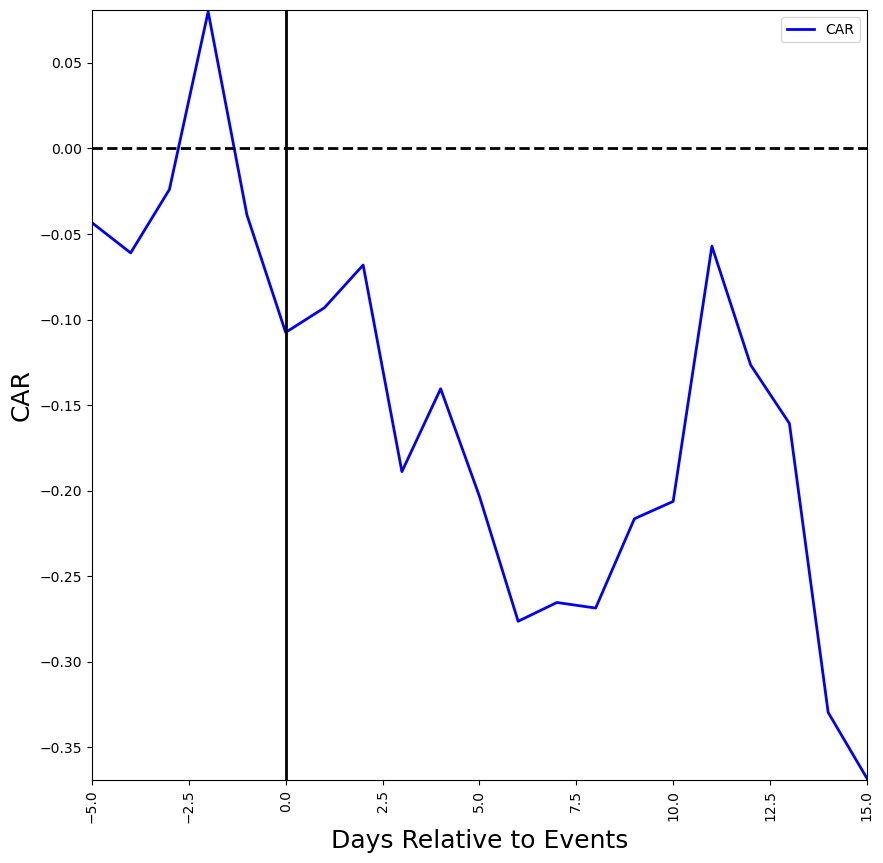

In [39]:
# Get dates vector for the plot (relative to event day 0)
date = np.arange(start_CAR, end_CAR + 1).reshape(-1, 1) # Reshape to a column vector

# Create a zero line for reference in the plot
zero = np.zeros((abs(start_CAR) + abs(end_CAR) + 1, 1)) # Shape matches date and CAAR

# Plot the Cumulative Average Abnormal Returns (CAAR)
CAAR_Plot = plt.figure(1)
# Plot CAAR line and zero line on the same plot
plt.plot(date, CAAR, '-b', date, zero, '--k', linewidth=2) # Use '-b' for blue line as in original plot
# Add a vertical line at x=0 (the event day)
plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
# Set y-axis label
plt.ylabel('CAR', fontsize=18) # Label as 'CAR' as in original plot
# Set x-axis label
plt.xlabel('Days Relative to Events', fontsize=18)
# Set x-axis limits
plt.xlim(start_CAR, end_CAR)
# Set y-axis limits with a small buffer
plt.ylim(min(CAAR) - 0.001, max(CAAR) + 0.001)
# Add a legend
plt.legend(['CAR']) # Legend label as 'CAR'
# Rotate x-axis ticks for readability
plt.xticks(rotation=90)
# Set figure size (using rcParams) - This might need adjustment depending on environment
plt.rcParams["figure.figsize"] = [10, 10]


# Save the plot as an EPS file based on the America flag
if America == 0:
    plt.savefig('CAAR_All.png', format='png')
else:
    plt.savefig('CAAR_America.png', format='png')

# plt.show() # Uncomment this line to display the plot when running the script
